# FX 量化快速入门

参考：

1. [量化实践](https://pytorch.org/blog/quantization-in-practice/)
2. [fx graph 模式 POST TRAINING STATIC QUANTIZATION](https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_static.html)

本教程介绍基于 {mod}`torch.fx` 在 graph 模式下进行训练后静态量化的步骤。FX Graph 模式量化的优点：可以在模型上完全自动地执行量化，尽管可能需要一些努力使模型与 FX Graph 模式量化兼容（象征性地用 {mod}`torch.fx` 跟踪），将有单独的教程来展示如何使我们想量化的模型的一部分与 FX Graph 模式量化兼容。也有 [FX Graph 模式后训练动态量化](https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_dynamic.html) 教程。FX Graph 模式 API 如下所示：


In [1]:
import torch
from torch import nn, fx
from torch.quantization import get_default_qconfig
from torch.quantization.quantize_fx import prepare_fx, convert_fx

class M(nn.Module):
    def forward(self, x):
        return x

float_model = M()
float_model.eval()
qconfig = get_default_qconfig("fbgemm")
qconfig_dict = {"": qconfig}
def calibrate(model, data_loader):
    model.eval()
    with torch.no_grad():
        for image, target in data_loader:
            model(image)

valset = []
prepared_model = prepare_fx(float_model, qconfig_dict)  # 融合模块并插入观测器
calibrate(prepared_model, valset)  # 在代表数据上运行校准
quantized_model = convert_fx(prepared_model)  # 转化校准后的模型为量化模型

/media/pc/data/4tb/lxw/libs/anaconda3/envs/tvmx/lib/python3.10/site-packages/torch/ao/quantization/observer.py:176: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


## FX Graph 模式量化的动机

目前 PyTorch 存在 eager 模式量化：[Static Quantization with Eager Mode in PyTorch](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html)。

可以看到，该过程涉及到多个手动步骤，包括：

- 显式地 quantize 和 dequantize activations，当浮点和量化运算混合在模型中时，这是非常耗时的。
- 显式融合模块，这需要手动识别卷积序列、 batch norms 以及 relus 和其他融合模式。
- PyTorch 张量运算需要特殊处理（如 `add`、`concat` 等）。
- 函数式没有  first class 支持（`functional.conv2d` 和 `functional.linear` 不会被量化）

这些需要的修改大多来自于 Eager 模式量化的潜在限制。Eager 模式在模块级工作，因为它不能检查实际运行的代码（在 `forward` 函数中），量化是通过模块交换实现的，不知道在 Eager 模式下 `forward` 函数中模块是如何使用的。因此，它需要用户手动插入 `QuantStub` 和 `DeQuantStub`，以标记他们想要 quantize 或 dequantize 的点。在图模式中，可以检查在 `forward` 函数中执行的实际代码（例如 `aten` 函数调用），量化是通过模块和 graph 操作实现的。由于图模式对运行的代码具有完全的可见性，能够自动地找出要融合哪些模块，在哪里插入 observer 调用，quantize/dequantize 函数等，能够自动化整个量化过程。

FX Graph 模式量化的优点是：

- 简化量化流程，最小化手动步骤
- 开启了进行更高级别优化的可能性，如自动精度选择（automatic precision selection）

## 定义辅助函数和 Prepare Dataset

首先进行必要的导入，定义一些辅助函数并准备数据。这些步骤与 PyTorch 中 [使用 Eager 模式的静态量化](https://pytorch.org/tutorials/advanced/static_quantization_tutorial.html) 相同。

要使用整个 ImageNet 数据集运行本教程中的代码，首先按照 [ImageNet Data](http://www.image-net.org/download) 中的说明下载 ImageNet。将下载的文件解压缩到 `data_path` 文件夹中。

下载 {mod}`torchvision resnet18 模型 <torchvision.models.resnet>` 并将其重命名为 `models/resnet18_pretrained_float.pth`。

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [30]:
2/7

0.2857142857142857

In [26]:
torch.optim.lr_scheduler.StepLR??

Init signature:
torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size,
    gamma=0.1,
    last_epoch=-1,
    verbose=False,
)
Source:        
class StepLR(_LRScheduler):
    """Decays the learning rate of each parameter group by gamma every
    step_size epochs. Notice that such decay can happen simultaneously with
    other changes to the learning rate from outside this scheduler. When
    last_epoch=-1, sets initial lr as lr.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        step_size (int): Period of learning rate decay.
        gamma (float): Multiplicative factor of learning rate decay.
            Default: 0.1.
        last_epoch (int): The index of last epoch. Default: -1.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.

    Example:
        >>> # Assuming optimizer uses lr = 0.05 for all groups
        >>> # lr = 0.05     if epoch < 30
        >>> # lr = 0.005    if 30 <= epoch < 60
    

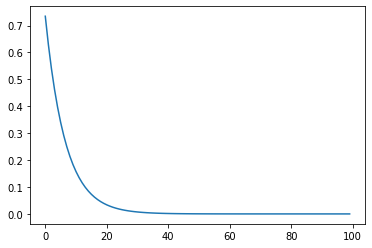

In [25]:
s = 0.857142
x = 0.857142
L = []
for k in range(100):
    x = x * s
    L.append(x)
y = np.array(L)
plt.plot(y)
plt.show()

In [7]:
5e-4

0.0005

In [2]:
from torch_book.data import ImageNet


root = "/media/pc/data/4tb/lxw/datasets/ILSVRC"
saved_model_dir = 'models/'

dataset = ImageNet(root)
trainset = dataset.loader(batch_size=30, split="train")
valset = dataset.loader(batch_size=50, split="val")

AttributeError: 'ImageNet' object has no attribute 'loader'

In [ ]:
import copy
from torchvision import models

model_name = "resnet18"
float_model = getattr(models, model_name)(pretrained=True)
float_model.eval()

# deepcopy the model since we need to keep the original model around
model_to_quantize = copy.deepcopy(float_model)

## 评估模式的模型

对于训练后量化，需要将模型设置为评估模式。

In [ ]:
model_to_quantize.eval();

## 使用 `qconfig_dict` 指定如何量化模型

```python
qconfig_dict = {"" : default_qconfig}
```

使用与 Eager 模式量化中相同的 `qconfig`, `qconfig` 只是用于激活和权重的 observers 的命名元组。`qconfig_dict` 是具有以下配置的字典：

```python
qconfig = {
    " : qconfig_global,
    "sub" : qconfig_sub,
    "sub.fc" : qconfig_fc,
    "sub.conv": None
}
qconfig_dict = {
    # qconfig? means either a valid qconfig or None
    # optional, global config
    "": qconfig?,
    # optional, used for module and function types
    # could also be split into module_types and function_types if we prefer
    "object_type": [
        (torch.nn.Conv2d, qconfig?),
        (torch.nn.functional.add, qconfig?),
        ...,
    ],
    # optional, used for module names
    "module_name": [
        ("foo.bar", qconfig?)
        ...,
    ],
    # optional, matched in order, first match takes precedence
    "module_name_regex": [
        ("foo.*bar.*conv[0-9]+", qconfig?)
        ...,
    ],
    # priority (in increasing order): global, object_type, module_name_regex, module_name
    # qconfig == None means fusion and quantization should be skipped for anything
    # matching the rule

    # **api subject to change**
    # optional: specify the path for standalone modules
    # These modules are symbolically traced and quantized as one unit
    # so that the call to the submodule appears as one call_module
    # node in the forward graph of the GraphModule
    "standalone_module_name": [
        "submodule.standalone"
    ],
    "standalone_module_class": [
        StandaloneModuleClass
    ]
}
```

可以在 [`qconfig` 文件](https://github.com/pytorch/pytorch/blob/master/torch/quantization/qconfig.py) 中找到与 `qconfig` 相关的实用函数：

In [ ]:
from torch.quantization import get_default_qconfig, quantize_jit

qconfig = get_default_qconfig("fbgemm")
qconfig_dict = {"": qconfig}

## 为静态后训练量化模型做准备

In [ ]:
import warnings
from torch.quantization.quantize_fx import prepare_fx

warnings.filterwarnings('ignore')

prepared_model = prepare_fx(model_to_quantize, qconfig_dict)

`prepare_fx` 将 BatchNorm 模块折叠到前面的 Conv2d 模块中，并在模型中的适当位置插入 observers。

In [ ]:
print(prepared_model.graph)

## 校准

将 observers 插入模型后，运行校准函数。校准的目的就是通过一些样本运行代表性的工作负载（例如样本的训练数据集）以便 observers 在模型中能够观测到张量的统计数据，以后使用这些信息来计算量化参数。

In [ ]:
import torch

def calibrate(model, data_loader, samples=500):
    model.eval()
    with torch.no_grad():
        k = 0
        for image, _ in data_loader:
            if k > samples:
                break
            model(image)
            k += len(image)

calibrate(prepared_model, trainset)  # run calibration on sample data

## 将模型转换为量化模型

`convert_fx` 采用校准模型并产生量化模型。

In [ ]:
from torch.quantization.quantize_fx import convert_fx

quantized_model = convert_fx(prepared_model)
print(quantized_model)

## 评估

现在可以打印量化模型的大小和精度。

In [ ]:
from torch_book.contrib.helper import evaluate, print_size_of_model
from torch import nn


criterion = nn.CrossEntropyLoss()

print("Size of model before quantization")
print_size_of_model(float_model)
print("Size of model after quantization")
print_size_of_model(quantized_model)
top1, top5 = evaluate(quantized_model, criterion, valset)

In [ ]:
print(f"[before serilaization] Evaluation accuracy on test dataset: {top1.avg:2.2f}, {top5.avg:2.2f}")

In [ ]:
fx_graph_mode_model_file_path = saved_model_dir + f"{model_name}_fx_graph_mode_quantized.pth"

# this does not run due to some erros loading convrelu module:
# ModuleAttributeError: 'ConvReLU2d' object has no attribute '_modules'
# save the whole model directly
# torch.save(quantized_model, fx_graph_mode_model_file_path)
# loaded_quantized_model = torch.load(fx_graph_mode_model_file_path)

# save with state_dict
# torch.save(quantized_model.state_dict(), fx_graph_mode_model_file_path)
# import copy
# model_to_quantize = copy.deepcopy(float_model)
# prepared_model = prepare_fx(model_to_quantize, {"": qconfig})
# loaded_quantized_model = convert_fx(prepared_model)
# loaded_quantized_model.load_state_dict(torch.load(fx_graph_mode_model_file_path))

# save with script
torch.jit.save(torch.jit.script(quantized_model), fx_graph_mode_model_file_path)
loaded_quantized_model = torch.jit.load(fx_graph_mode_model_file_path)

top1, top5 = evaluate(loaded_quantized_model, criterion, valset)

In [ ]:
print(f"[after serialization/deserialization] Evaluation accuracy on test dataset: {top1.avg:2.2f}, {top5.avg:2.2f}")

如果希望获得更好的精度或性能，请尝试更改 `qconfig_dict`。

## 调试量化模型

还可以打印量化的 un-quantized conv 的权重来查看区别，首先显式地调用 `fuse` 来融合模型中的 conv 和 bn：注意，`fuse_fx` 只在 `eval` 模式下工作。

In [ ]:
from torch.quantization.quantize_fx import fuse_fx

fused = fuse_fx(float_model)

conv1_weight_after_fuse = fused.conv1[0].weight[0]
conv1_weight_after_quant = quantized_model.conv1.weight().dequantize()[0]

print(torch.max(abs(conv1_weight_after_fuse - conv1_weight_after_quant)))

## 基线浮点模型和 Eager 模式量化的比较

In [ ]:
scripted_float_model_file = "resnet18_scripted.pth"

print("Size of baseline model")
print_size_of_model(float_model)

top1, top5 = evaluate(float_model, criterion, valset)
print("Baseline Float Model Evaluation accuracy: %2.2f, %2.2f"%(top1.avg, top5.avg))
torch.jit.save(torch.jit.script(float_model), saved_model_dir + scripted_float_model_file)

在本节中，将量化模型与 FX Graph 模式的量化模型与在 Eager 模式下量化的模型进行比较。FX Graph 模式和 Eager 模式产生的量化模型非常相似，因此期望精度和 speedup 也很相似。

In [ ]:
print("Size of Fx graph mode quantized model")
print_size_of_model(quantized_model)
top1, top5 = evaluate(quantized_model, criterion, valset)
print("FX graph mode quantized model Evaluation accuracy on test dataset: %2.2f, %2.2f"%(top1.avg, top5.avg))

from torchvision.models.quantization.resnet import resnet18
eager_quantized_model = resnet18(pretrained=True, quantize=True).eval()
print("Size of eager mode quantized model")
eager_quantized_model = torch.jit.script(eager_quantized_model)
print_size_of_model(eager_quantized_model)
top1, top5 = evaluate(eager_quantized_model, criterion, valset)
print("eager mode quantized model Evaluation accuracy on test dataset: %2.2f, %2.2f"%(top1.avg, top5.avg))
eager_mode_model_file = "resnet18_eager_mode_quantized.pth"
torch.jit.save(eager_quantized_model, saved_model_dir + eager_mode_model_file)

可以看到 FX Graph 模式和 Eager 模式量化模型的模型大小和精度是非常相似的。

在 AIBench 中运行模型（单线程）会得到如下结果：

```log
Scripted Float Model:
Self CPU time total: 192.48ms

Scripted Eager Mode Quantized Model:
Self CPU time total: 50.76ms

Scripted FX Graph Mode Quantized Model:
Self CPU time total: 50.63ms
```

可以看到，对于 resnet18, FX Graph 模式和 Eager 模式量化模型都比浮点模型获得了相似的速度，大约比浮点模型快 2-4 倍。但是浮点模型上的实际加速可能会因模型、设备、构建、输入批大小、线程等而不同。